# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import csv
import math
import numpy as np
from PIL import Image
import pandas as pd

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Great_Lakes_Lab/trial')

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the training data from train.csv file

In [48]:
pip install patool


In [0]:
import patoolib

In [55]:

patoolib.extract_archive("images_racoon.rar")

patool: Extracting images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Great_Lakes_Lab/trial/images_racoon.rar"
patool:     with cwd='./Unpack_f9zcul_q'
patool: ... images_racoon.rar extracted to `images_racoon' (local file exists).


'images_racoon'

In [0]:
import zipfile
with zipfile.ZipFile("images_racoon.zip","r") as zip_ref:
    zip_ref.extractall()

### Print the shape of the train dataset

In [0]:
train_labels = pd.read_csv("train_labels.csv")

In [14]:
train_labels.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
TRAIN_CSV="train_labels.csv"
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
               
        #for i, r in enumerate(row[1:7]): # Parse row with seven entities
            #row[i+1] = int(r)
              
        path, image_width,image_height,_, x0, y0, x1, y1, = row  
        #path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
        path = "/content/drive/My Drive/Great_Lakes_Lab/trial/images/"+ path
        coords[col, 0] = int(x0) * (IMAGE_SIZE) / int(image_width) # Normalize bounding box by image size
        coords[col, 1] = int(y0) * (IMAGE_SIZE) / int(image_height) # Normalize bounding box by image size
        coords[col, 2] = (int(x1) - int(x0)) * (IMAGE_SIZE) / int(image_width) # Normalize bounding box by image size
        coords[col, 3] = (int(y1) - int(y0)) * (IMAGE_SIZE) / int(image_height)
        paths.append(path)



### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

DATASET_FOLDER = "/content/drive/My Drive/Great_Lakes_Lab/trial/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

images_zip_path = DATASET_FOLDER + "/images/"

#from zipfile import ZipFile

#with ZipFile(images_zip_path, 'r') as z:
  #z.extractall()

In [22]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

17227776/17225924 [==============================] - 0s 0us/step


In [58]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128   

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt=coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [69]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,initial_epoch=10,batch_size = 32,verbose=1)

Train on 173 samples
Epoch 11/30
173/173 [==============================] - 5s 30ms/sample - loss: 153.1163 - IoU: 0.7022
Epoch 12/30
173/173 [==============================] - 4s 23ms/sample - loss: 116.9073 - IoU: 0.7441
Epoch 13/30
173/173 [==============================] - 4s 23ms/sample - loss: 93.7330 - IoU: 0.7634
Epoch 14/30
173/173 [==============================] - 4s 23ms/sample - loss: 79.9270 - IoU: 0.7907
Epoch 15/30
173/173 [==============================] - 4s 22ms/sample - loss: 66.9848 - IoU: 0.7995
Epoch 16/30
173/173 [==============================] - 4s 22ms/sample - loss: 71.3089 - IoU: 0.8055
Epoch 17/30
173/173 [==============================] - 4s 23ms/sample - loss: 64.6051 - IoU: 0.8239
Epoch 18/30
173/173 [==============================] - 4s 23ms/sample - loss: 62.1934 - IoU: 0.8237
Epoch 19/30
173/173 [==============================] - 4s 23ms/sample - loss: 57.6692 - IoU: 0.8317
Epoch 20/30
173/173 [==============================] - 4s 24ms/sample - loss:

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/Great_Lakes_Lab/trial/images/raccoon-2.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

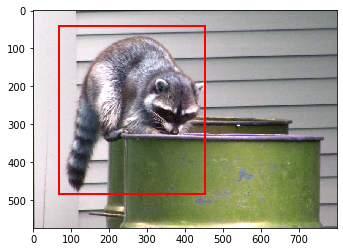

In [73]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

In [0]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras  import callbacks
from tensorflow.keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

In [0]:
import os
os.chdir('/content/drive/My Drive/Great_Lakes_Lab/trial')

### Load your data file

In [81]:
dataset=pd.read_csv("daily-minimum-temperatures-in-me.csv")
dataset.head(5)

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

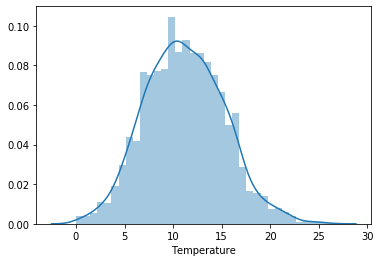

In [83]:
import seaborn as sns
sns.distplot(dataset.Temperature)

#### Descibe your dataframe

In [84]:
dataset.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [80]:
dataset.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

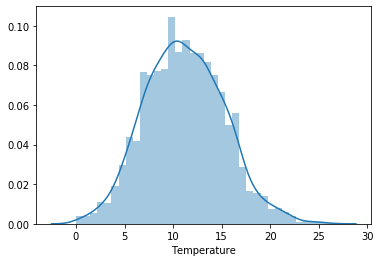

In [85]:
sns.distplot(dataset.Temperature, hist = True)

#### Check the maximum and minimum values

In [86]:
print("Minimum Temp = ", dataset.Temperature.min())
print("Max Temp = ", dataset.Temperature.max())

Minimum Temp =  0.0
Max Temp =  26.3


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
#apply the sclaing to make values between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(np.asarray(dataset.Temperature).reshape(-1,1))


#### Check the maximum and minimum values of scaled data

In [89]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [90]:
print(scaled[:10])

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159696]
 [0.82889734]
 [0.76045627]]


### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [92]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back):
        
        
        a = dataset[i:(i+look_back), 0]
        
        dataX.append(a)
        
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [95]:
len(X_train)

2554

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [96]:
#samples, time_steps, features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(tf.keras.layers.LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')

### Summarize your model

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    96        
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [99]:
model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2, shuffle=True)

Train on 2554 samples
Epoch 1/50
2554/2554 - 5s - loss: 0.0370
Epoch 2/50
2554/2554 - 4s - loss: 0.0257
Epoch 3/50
2554/2554 - 4s - loss: 0.0221
Epoch 4/50
2554/2554 - 4s - loss: 0.0192
Epoch 5/50
2554/2554 - 4s - loss: 0.0175
Epoch 6/50
2554/2554 - 4s - loss: 0.0159
Epoch 7/50
2554/2554 - 4s - loss: 0.0149
Epoch 8/50
2554/2554 - 4s - loss: 0.0143
Epoch 9/50
2554/2554 - 4s - loss: 0.0140
Epoch 10/50
2554/2554 - 4s - loss: 0.0131
Epoch 11/50
2554/2554 - 4s - loss: 0.0128
Epoch 12/50
2554/2554 - 4s - loss: 0.0123
Epoch 13/50
2554/2554 - 4s - loss: 0.0120
Epoch 14/50
2554/2554 - 4s - loss: 0.0116
Epoch 15/50
2554/2554 - 4s - loss: 0.0116
Epoch 16/50
2554/2554 - 4s - loss: 0.0115
Epoch 17/50
2554/2554 - 4s - loss: 0.0111
Epoch 18/50
2554/2554 - 4s - loss: 0.0109
Epoch 19/50
2554/2554 - 4s - loss: 0.0107
Epoch 20/50
2554/2554 - 4s - loss: 0.0106
Epoch 21/50
2554/2554 - 4s - loss: 0.0105
Epoch 22/50
2554/2554 - 4s - loss: 0.0105
Epoch 23/50
2554/2554 - 4s - loss: 0.0103
Epoch 24/50
2554/2554

## Make Predictions and Evaluate your model

In [100]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.47 RMSE


## Plot the results

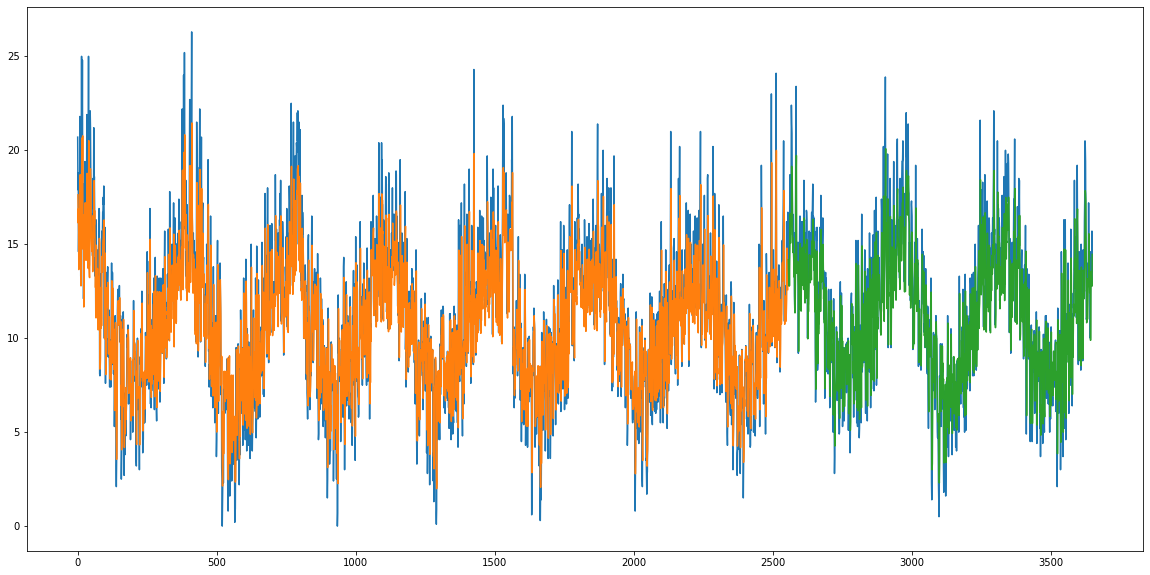

In [101]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()